In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID 컬럼 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
train.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률
0,2009,CT005,이커머스,Series A,4126.0,No,No,56.0,3365.0,4764.0,4.71,NaN,0.3
1,2023,CT006,핀테크,Seed,4167.0,Yes,No,80.0,4069.0,279.0,1.00,2500-3500,0.8
2,2018,CT007,기술,Series A,3132.0,Yes,Yes,54.0,6453.0,12141.0,4.00,3500-4500,0.5
3,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7
4,2020,CT002,에듀테크,Seed,1969.0,No,Yes,94.0,829.0,9810.0,1.00,1500-2500,0.1


In [5]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if '이상' in val:
        # '6000이상' → 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' → 평균값 계산
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # 숫자로 변환 가능한 경우
        try:
            return float(val)
        except:
            return None


In [6]:
# 설립연도 -> 연차로 변경
current_year = 2025

train['연차'] = current_year - train['설립연도']
test['연차'] = current_year - test['설립연도']

# 설립연도 제거
train.drop(columns = ['설립연도'], inplace = True)
test.drop(columns = ['설립연도'], inplace = True)

category_features = ['국가','분야']
numeric_features = ['연차', '투자단계', '직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)', '기업가치(백억원)']
bool_features = ['인수여부','상장여부']

# 투자단계 순서를 숫자로 매핑
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# 결측치 먼저 처리 후 매핑
train['투자단계'] = train['투자단계'].fillna('Missing').map(investment_stage_map)
test['투자단계'] = test['투자단계'].fillna('Missing').map(investment_stage_map)

# 기업가치 변환
train['기업가치(백억원)'] = train['기업가치(백억원)'].apply(clean_valuation)
test['기업가치(백억원)'] = test['기업가치(백억원)'].apply(clean_valuation)

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# 수치형 변수 결측치를 중간값으로 대체
for feature in numeric_features:
    median_value = train[feature].median()
    train[feature] = train[feature].fillna(median_value)
    test[feature] = test[feature].fillna(median_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [7]:
# 1인당 지표
train['투자_1인당'] = train['총 투자금(억원)'] / train['직원 수']
train['매출_1인당'] = train['연매출(억원)'] / train['직원 수']

# 비율 지표
train['투자대비매출'] = train['연매출(억원)'] / (train['총 투자금(억원)'] + 1e-6)  # 0 나누기 방지
train['가치대비투자비율'] = train['총 투자금(억원)'] / (train['기업가치(백억원)'] + 1e-6)
train['고객당매출'] = train['연매출(억원)'] / (train['고객수(백만명)'] + 1e-6)

# 스케일 변환
train['연차_루트'] = np.sqrt(train['연차'])


In [8]:
test['투자_1인당'] = test['총 투자금(억원)'] / test['직원 수']
test['매출_1인당'] = test['연매출(억원)'] / test['직원 수']
test['투자대비매출'] = test['연매출(억원)'] / (test['총 투자금(억원)'] + 1e-6)
test['가치대비투자비율'] = test['총 투자금(억원)'] / (test['기업가치(백억원)'] + 1e-6)
test['고객당매출'] = test['연매출(억원)'] / (test['고객수(백만명)'] + 1e-6)
test['연차_루트'] = np.sqrt(test['연차'])


In [9]:
features += [
    '투자_1인당', '매출_1인당', '투자대비매출',
    '가치대비투자비율', '고객당매출', '연차_루트'
]


In [10]:
for df in [train, test]:
    df['투자_회수율'] = df['기업가치(백억원)'] / (df['총 투자금(억원)'] + 1e-6)
    df['SNS_노출도'] = df['SNS 팔로워 수(백만명)'] / (df['고객수(백만명)'] + 1e-6)
    df['SNS_영향력'] = df['SNS 팔로워 수(백만명)'] / (df['기업가치(백억원)'] + 1e-6)
    df['직원당_고객수'] = df['고객수(백만명)'] / (df['직원 수'] + 1e-6)
    df['연매출_비율'] = df['연매출(억원)'] / (df['기업가치(백억원)'] + 1e-6)
    df['성장도'] = df['연매출(억원)'] / (df['연차'] + 1e-6)


In [11]:
features += [
    '투자_회수율', 'SNS_노출도', 'SNS_영향력',
    '직원당_고객수', '연매출_비율', '성장도'
]


In [12]:
# features 리스트에서 제거
features = [f for f in features if f not in ['국가', '분야', '투자단계']]


In [13]:
features = [f for f in features if f not in ['인수여부', '상장여부', '직원 수']]


In [14]:
for df in [train, test]:
    df['팔로워당_매출'] = df['연매출(억원)'] / (df['SNS 팔로워 수(백만명)'] + 1e-6)

In [15]:
features = [f for f in features if f not in ['SNS 팔로워 수(백만명)']]


In [16]:
features += [
    '팔로워당_매출'
]


In [32]:
features

['고객수(백만명)',
 '총 투자금(억원)',
 '연매출(억원)',
 '기업가치(백억원)',
 '연차',
 '투자_1인당',
 '매출_1인당',
 '투자대비매출',
 '가치대비투자비율',
 '고객당매출',
 '연차_루트',
 '투자_회수율',
 'SNS_노출도',
 'SNS_영향력',
 '직원당_고객수',
 '연매출_비율',
 '성장도',
 '팔로워당_매출']

In [26]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 1. KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Optuna objective 함수 정의 (KFold 기반)
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 15, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'seed': 42
    }

    mae_list = []

    for train_idx, valid_idx in kf.split(train[features]):
        X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
        y_train, y_valid = train.iloc[train_idx]['성공확률'], train.iloc[valid_idx]['성공확률']

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=40,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        mae = mean_absolute_error(y_valid, preds)
        mae_list.append(mae)

    return np.mean(mae_list)  # 모든 Fold 평균 MAE

# 3. Optuna study 실행
study = optuna.create_study(direction='minimize')  # MAE 작을수록 좋음
study.optimize(objective, n_trials=200)

# 4. 결과 출력
print("✅ Best trial:")
print(study.best_trial)


[I 2025-04-11 11:50:45,194] A new study created in memory with name: no-name-2a2255c2-77dd-44b6-a4ad-ca68d9a2c326
[I 2025-04-11 11:50:47,449] Trial 0 finished with value: 0.19865429196135095 and parameters: {'learning_rate': 0.07368825037043164, 'max_depth': 19, 'subsample': 0.8739633239866847, 'colsample_bytree': 0.6804743383530465, 'lambda': 0.0036398104425293346, 'alpha': 0.002517828841449881}. Best is trial 0 with value: 0.19865429196135095.
[I 2025-04-11 11:50:48,730] Trial 1 finished with value: 0.2005072493795111 and parameters: {'learning_rate': 0.07096328744820299, 'max_depth': 16, 'subsample': 0.9301959184502052, 'colsample_bytree': 0.6889997697158943, 'lambda': 0.006697591307452417, 'alpha': 0.3076564510111688}. Best is trial 0 with value: 0.19865429196135095.
[I 2025-04-11 11:50:49,249] Trial 2 finished with value: 0.20419022329115358 and parameters: {'learning_rate': 0.07028472035272754, 'max_depth': 20, 'subsample': 0.5706996796318515, 'colsample_bytree': 0.99902317746972

✅ Best trial:
FrozenTrial(number=186, state=1, values=[0.1968445734223772], datetime_start=datetime.datetime(2025, 4, 11, 12, 10, 20, 171801), datetime_complete=datetime.datetime(2025, 4, 11, 12, 10, 27, 482228), params={'learning_rate': 0.014933134828299523, 'max_depth': 20, 'subsample': 0.9998956482182519, 'colsample_bytree': 0.5469862742477296, 'lambda': 0.11576768193539966, 'alpha': 0.009618442688938555}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=20, log=False, low=15, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None)}, trial_id=186, value=None)


## SNS 유지

In [ ]:
    'learning_rate': 0.03674126205475308,
    'max_depth': 18,
    'subsample': 0.9658901119807219,
    'colsample_bytree': 0.5585452433150189,
    'lambda': 0.06731590651355367,
    'alpha': 0.012920079201935733,

## SNS 제거 후 팔로워 당 매출 추가

In [ ]:
    'learning_rate': 0.018017876773443166,
    'max_depth': 20,
    'subsample': 0.9655481107853634,
    'colsample_bytree': 0.5143355494315199,
    'lambda': 0.052245775093023056,
    'alpha': 0.004287654477045353,

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['성공확률']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.018017876773443166,
    'max_depth': 20,
    'subsample': 0.9655481107853634,
    'colsample_bytree': 0.5143355494315199,
    'lambda': 0.052245775093023056,
    'alpha': 0.004287654477045353,
    'tree_method': 'hist',
    'seed': 42
}




for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  🔍 Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n✅ 모든 fold 모델 학습 완료!")
print(f"📉 평균 MAE: {sum(cv_scores)/len(cv_scores):.4f}")



🔁 Fold 1/10
[0]	train-mae:0.20281	valid-mae:0.20728
[100]	train-mae:0.05252	valid-mae:0.19613
[152]	train-mae:0.02656	valid-mae:0.19622
  🔍 Fold 1 MAE: 0.1962

🔁 Fold 2/10
[0]	train-mae:0.20360	valid-mae:0.19086
[100]	train-mae:0.05434	valid-mae:0.18605
[121]	train-mae:0.04061	valid-mae:0.18576
  🔍 Fold 2 MAE: 0.1857

🔁 Fold 3/10
[0]	train-mae:0.20138	valid-mae:0.21712
[100]	train-mae:0.05393	valid-mae:0.20263
[200]	train-mae:0.01495	valid-mae:0.20078
[300]	train-mae:0.00456	valid-mae:0.20055
[400]	train-mae:0.00188	valid-mae:0.20044
[500]	train-mae:0.00105	valid-mae:0.20043
[600]	train-mae:0.00086	valid-mae:0.20041
[664]	train-mae:0.00084	valid-mae:0.20041
  🔍 Fold 3 MAE: 0.2004

🔁 Fold 4/10
[0]	train-mae:0.20237	valid-mae:0.19970
[100]	train-mae:0.05498	valid-mae:0.19439
[200]	train-mae:0.01618	valid-mae:0.19364
[298]	train-mae:0.00546	valid-mae:0.19360
  🔍 Fold 4 MAE: 0.1936

🔁 Fold 5/10
[0]	train-mae:0.20147	valid-mae:0.21548
[100]	train-mae:0.05430	valid-mae:0.20953
[138]	train-m

In [36]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

X = train[features]
y = train['성공확률']

# ✅ 여러 개 seed 설정
seeds = [42, 77, 123]
n_splits = 10

models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.018017876773443166,
    'max_depth': 20,
    'subsample': 0.9655481107853634,
    'colsample_bytree': 0.5143355494315199,
    'lambda': 0.052245775093023056,
    'alpha': 0.004287654477045353,
    'tree_method': 'hist'
}

# ✅ seed마다 KFold 10회씩 실행
for seed in seeds:
    print(f"\n🧪 Seed {seed} 시작")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Seed {seed} - Fold {fold+1}/{n_splits}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params={**params, 'seed': seed},
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=50,
            verbose_eval=100
        )

        preds = model.predict(dvalid)
        score = mean_absolute_error(y_valid, preds)
        print(f"  🔍 Fold MAE: {score:.4f}")

        models.append(model)
        cv_scores.append(score)

# ✅ 전체 결과 출력
print("\n✅ 모든 Seed-Fold 모델 학습 완료!")
print(f"📉 평균 MAE (Across All Seeds): {np.mean(cv_scores):.4f}")



🧪 Seed 42 시작

🔁 Seed 42 - Fold 1/10
[0]	train-mae:0.20227	valid-mae:0.20078
[100]	train-mae:0.04962	valid-mae:0.19408
[177]	train-mae:0.01759	valid-mae:0.19353
  🔍 Fold MAE: 0.1935

🔁 Seed 42 - Fold 2/10
[0]	train-mae:0.20155	valid-mae:0.20974
[100]	train-mae:0.05294	valid-mae:0.19721
[200]	train-mae:0.01461	valid-mae:0.19532
[300]	train-mae:0.00455	valid-mae:0.19506
[400]	train-mae:0.00183	valid-mae:0.19495
[500]	train-mae:0.00101	valid-mae:0.19492
[600]	train-mae:0.00087	valid-mae:0.19491
[601]	train-mae:0.00087	valid-mae:0.19491
  🔍 Fold MAE: 0.1949

🔁 Seed 42 - Fold 3/10
[0]	train-mae:0.20142	valid-mae:0.21021
[100]	train-mae:0.05568	valid-mae:0.20369
[188]	train-mae:0.01867	valid-mae:0.20328
  🔍 Fold MAE: 0.2033

🔁 Seed 42 - Fold 4/10
[0]	train-mae:0.20246	valid-mae:0.20104
[100]	train-mae:0.05500	valid-mae:0.19607
[200]	train-mae:0.01592	valid-mae:0.19514
[300]	train-mae:0.00505	valid-mae:0.19486
[305]	train-mae:0.00477	valid-mae:0.19484
  🔍 Fold MAE: 0.1948

🔁 Seed 42 - Fold 5/

In [39]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

X = train[features]
y = train['성공확률']

# ✅ 여러 개 seed 설정
seeds = [13, 42, 77, 123, 999]
n_splits = 10

models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.018017876773443166,
    'max_depth': 20,
    'subsample': 0.9655481107853634,
    'colsample_bytree': 0.5143355494315199,
    'lambda': 0.052245775093023056,
    'alpha': 0.004287654477045353,
    'tree_method': 'hist'
}

# ✅ seed마다 KFold 10회씩 실행
for seed in seeds:
    print(f"\n🧪 Seed {seed} 시작")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Seed {seed} - Fold {fold+1}/{n_splits}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params={**params, 'seed': seed},
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=50,
            verbose_eval=100
        )

        preds = model.predict(dvalid)
        score = mean_absolute_error(y_valid, preds)
        print(f"  🔍 Fold MAE: {score:.4f}")

        models.append(model)
        cv_scores.append(score)

# ✅ 전체 결과 출력
print("\n✅ 모든 Seed-Fold 모델 학습 완료!")
print(f"📉 평균 MAE (Across All Seeds): {np.mean(cv_scores):.4f}")



🧪 Seed 13 시작

🔁 Seed 13 - Fold 1/10
[0]	train-mae:0.20207	valid-mae:0.20589
[100]	train-mae:0.05046	valid-mae:0.19762
[200]	train-mae:0.01379	valid-mae:0.19669
[300]	train-mae:0.00429	valid-mae:0.19653
[400]	train-mae:0.00179	valid-mae:0.19644
[500]	train-mae:0.00101	valid-mae:0.19643
[507]	train-mae:0.00099	valid-mae:0.19643
  🔍 Fold MAE: 0.1964

🔁 Seed 13 - Fold 2/10
[0]	train-mae:0.20259	valid-mae:0.20207
[100]	train-mae:0.05518	valid-mae:0.19261
[200]	train-mae:0.01508	valid-mae:0.19199
[224]	train-mae:0.01129	valid-mae:0.19199
  🔍 Fold MAE: 0.1920

🔁 Seed 13 - Fold 3/10
[0]	train-mae:0.20218	valid-mae:0.20741
[100]	train-mae:0.05217	valid-mae:0.20006
[200]	train-mae:0.01451	valid-mae:0.19913
[300]	train-mae:0.00476	valid-mae:0.19908
[390]	train-mae:0.00210	valid-mae:0.19907
  🔍 Fold MAE: 0.1991

🔁 Seed 13 - Fold 4/10
[0]	train-mae:0.20169	valid-mae:0.20792
[100]	train-mae:0.05317	valid-mae:0.19972
[200]	train-mae:0.01475	valid-mae:0.19870
[300]	train-mae:0.00467	valid-mae:0.19846

In [40]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ← 여기가 핵심

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix 입력
    predictions_list.append(preds)

# 평균 예측
final_predictions = np.mean(predictions_list, axis=0)

# 제출 파일 생성
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./0410_15_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10
Predict with fold 11
Predict with fold 12
Predict with fold 13
Predict with fold 14
Predict with fold 15
Predict with fold 16
Predict with fold 17
Predict with fold 18
Predict with fold 19
Predict with fold 20
Predict with fold 21
Predict with fold 22
Predict with fold 23
Predict with fold 24
Predict with fold 25
Predict with fold 26
Predict with fold 27
Predict with fold 28
Predict with fold 29
Predict with fold 30
Predict with fold 31
Predict with fold 32
Predict with fold 33
Predict with fold 34
Predict with fold 35
Predict with fold 36
Predict with fold 37
Predict with fold 38
Predict with fold 39
Predict with fold 40
Predict with fold 41
Predict with fold 42
Predict with fold 43
Predict with fold 44
Predict with fold 45
Predict with fold 46
Predict with fold 47
Predict with fold 48
P

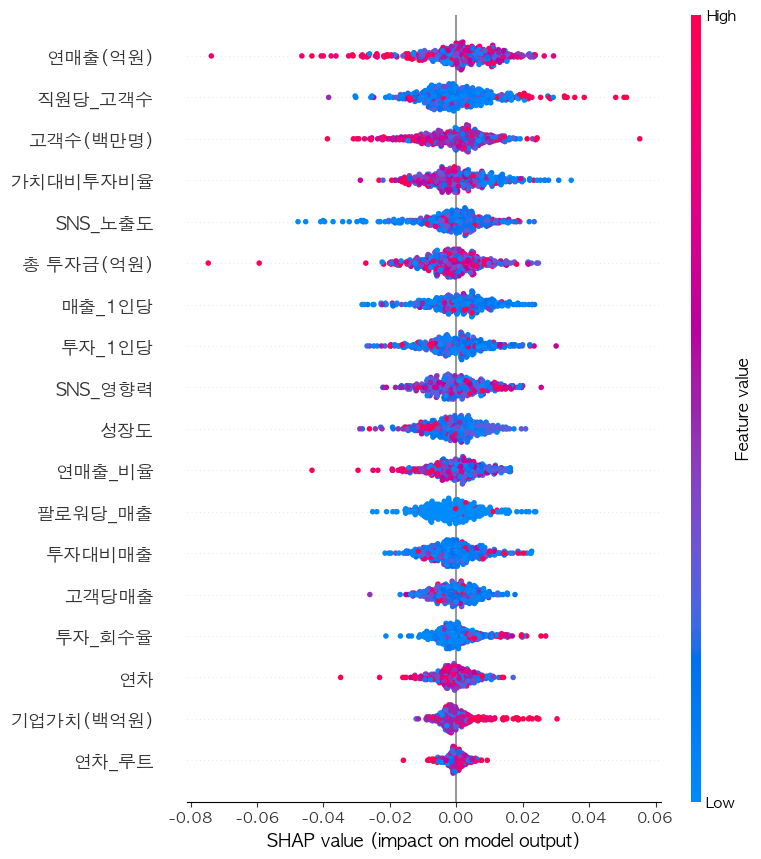

In [108]:
import shap
import matplotlib.pyplot as plt

# macOS: AppleGothic 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


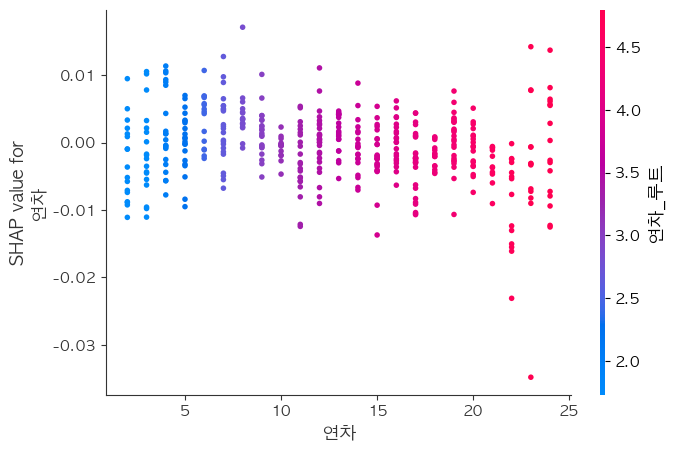

In [ ]:
shap.dependence_plot("총 투자금(억원)", shap_values, X_valid)
